In [0]:
#imports cell 
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense,Input,Flatten,GlobalAveragePooling2D,Dropout,BatchNormalization,Conv2D,Activation,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K
K.set_image_data_format("channels_first")
from tensorflow.keras import optimizers,Sequential

## Mount the Google Drive to Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Method for Loading dataset into Memory 

In [0]:
def load_data(plane,label):
  train_X = np.load('/content/gdrive/My Drive/Dataset/Transformations/mid3_train_'+plane+'.npy')
  train_y = np.genfromtxt('/content/gdrive/My Drive/Dataset/MRNet-v1.0/train-'+label+'.csv',delimiter=',')[:,1]
  val_X = np.load('/content/gdrive/My Drive/Dataset/Transformations/mid3_valid_'+plane+'.npy')
  val_y = np.genfromtxt('/content/gdrive/My Drive/Dataset/MRNet-v1.0/valid-'+label+'.csv',delimiter=',')[:,1]
  return train_X,train_y,val_X,val_y

## Defining Our Base Model upon which Transfer Learning is done

In [4]:
base_model = ResNet50(weights='imagenet',input_shape=(3,256,256),include_top=False,input_tensor=Input(shape=(3,256,256)))
for layer in base_model.layers:
  layer.trainable = False

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


## Defining our Model Built over Base Model and it's Methods

In [0]:
def build_model():
  model = base_model.output
  model = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(model)
  model = BatchNormalization()(model)
  model = Activation('relu')(model)
  model = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(model)
  model = BatchNormalization()(model)
  model = Activation('relu')(model)
  model = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(model)
  model = Flatten()(model)
  model = Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(model)
  model = Dropout(0.5)(model)
  model = Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001))(model)
  model = Dropout(0.5)(model)
  preds = Dense(1,activation='sigmoid',name='preds')(model)
  model_final=Model(inputs=base_model.input,outputs=preds)
  sgd = optimizers.SGD(lr=0.005)
  model_final.compile(optimizer= sgd,loss='binary_crossentropy',metrics=['accuracy'])
  return model_final
  
def show_model(model):
  model.summary()

def train_model(model,plane,label):
  train_X,train_y,val_X,val_y = load_data(plane,label)
  class_weights = class_weight.compute_class_weight('balanced',np.unique(train_y),train_y)
  class_weights_dict = dict(enumerate(class_weights))
  val_sample_weights = class_weight.compute_sample_weight('balanced', val_y)
  mc = ModelCheckpoint('/content/gdrive/My Drive/Models/TransferLearning/'+plane+'_'+label+'.h5', monitor='val_acc', mode='max', verbose=2, save_best_only=True)
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience= 3)
  history = model.fit(x=train_X, y=train_y,  validation_data=(val_X,val_y), batch_size = 20, epochs=50,verbose=2, callbacks=[mc,es], class_weight=class_weights_dict)
  return history
  
def plot_history(histories, key='acc'):
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val',color='b')
    plt.plot(history.epoch, history.history[key], color='b',
             label=name.title()+' Train')
  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()
  plt.ylim([0,1])
  plt.xlim([0,max(history.epoch)])
  plt.figure(0)
  plt.show()
  
  plt.figure(figsize=(16,10))
  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_loss'],
                   '--', label=name.title()+' Val',color='r')
    plt.plot(history.epoch, history.history['loss'], color='r',
             label=name.title()+' Train')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.ylim([0,1.5])
  plt.xlim([0,max(history.epoch)])
  plt.show()

## This is How the Final model looks like 

In [0]:
model = build_model()
show_model(model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 256, 256)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 3, 262, 262)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 128, 128) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 64, 128, 128) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

# Let's Begin Training the Net

## Model 1: Axial Plane and ACL Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/100

Epoch 00001: val_acc improved from -inf to 0.49167, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_acl.h5
 - 13s - loss: 1.1464 - acc: 0.5487 - val_loss: 1.0067 - val_acc: 0.4917
Epoch 2/100

Epoch 00002: val_acc improved from 0.49167 to 0.63333, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_acl.h5
 - 7s - loss: 1.0232 - acc: 0.6248 - val_loss: 0.9743 - val_acc: 0.6333
Epoch 3/100

Epoch 00003: val_acc did not improve from 0.63333
 - 6s - loss: 0.9504 - acc: 0.6611 - val_loss: 1.1624 - val_acc: 0.4500
Epoch 4/100

Epoch 00004: val_acc did not improve from 0.63333
 - 6s - loss: 0.9135 - acc: 0.7027 - val_loss: 0.9625 - val_acc: 0.5833
Epoch 5/100

Epoch 00005: val_acc improved from 0.63333 to 0.70000, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_acl.h5
 - 9s - loss: 0.8805 - acc: 0.7319 - val_loss: 0.9267 - val_acc: 0.7000
Epoch 6/100

Epoch 00006: val_a

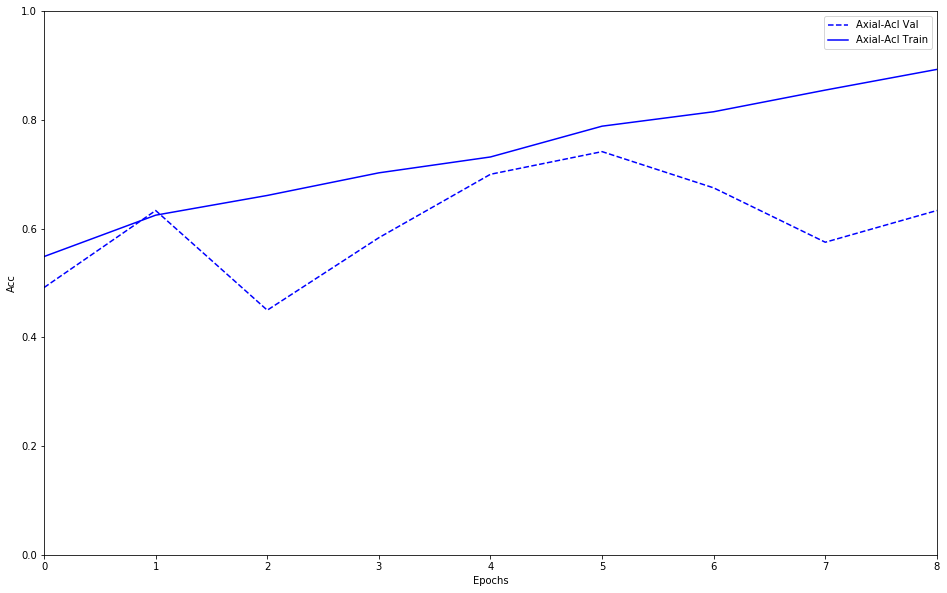

<Figure size 432x288 with 0 Axes>

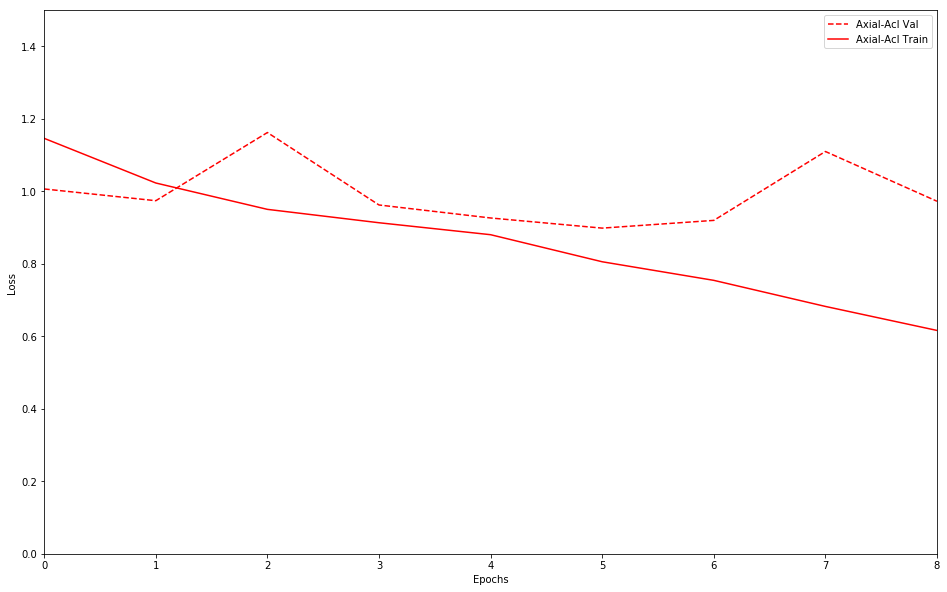

In [29]:
model = build_model()
history = train_model(model,"axial","acl")
plot_history([('Axial-ACL',history)])

## Model 2: Axial Plane and Abnormal Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.79167, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_abnormal.h5
 - 18s - loss: 1.0654 - acc: 0.5823 - val_loss: 1.0030 - val_acc: 0.7917
Epoch 2/50

Epoch 00002: val_acc improved from 0.79167 to 0.80000, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_abnormal.h5
 - 7s - loss: 0.8349 - acc: 0.6903 - val_loss: 0.9054 - val_acc: 0.8000
Epoch 3/50

Epoch 00003: val_acc improved from 0.80000 to 0.88333, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_abnormal.h5
 - 7s - loss: 0.7179 - acc: 0.7522 - val_loss: 0.7091 - val_acc: 0.8833
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.88333
 - 6s - loss: 0.6228 - acc: 0.8035 - val_loss: 0.6315 - val_acc: 0.8750
Epoch 5/50

Epoch 00005: val_acc improved from 0.88333 to 0.89167, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_abnormal.h5
 - 9s

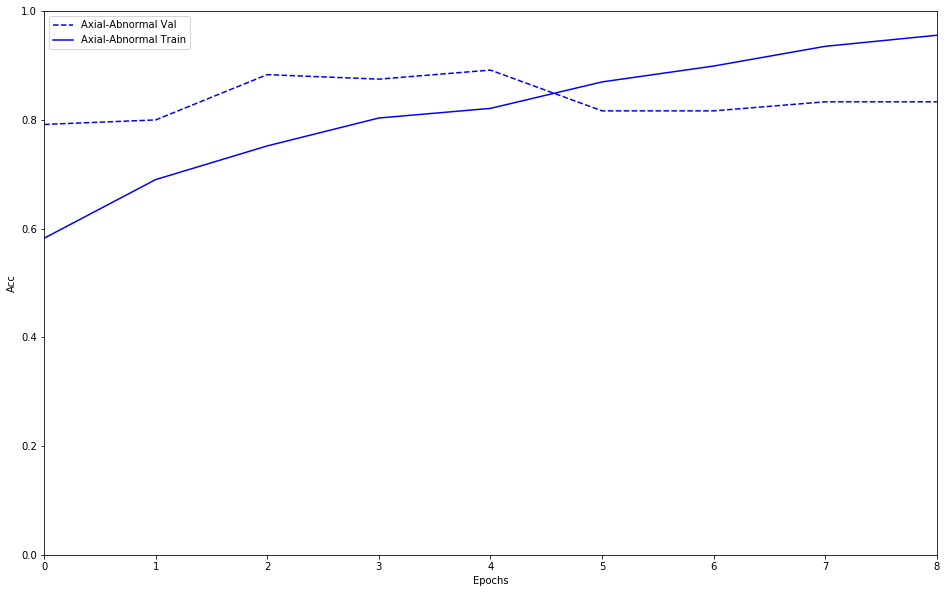

<Figure size 432x288 with 0 Axes>

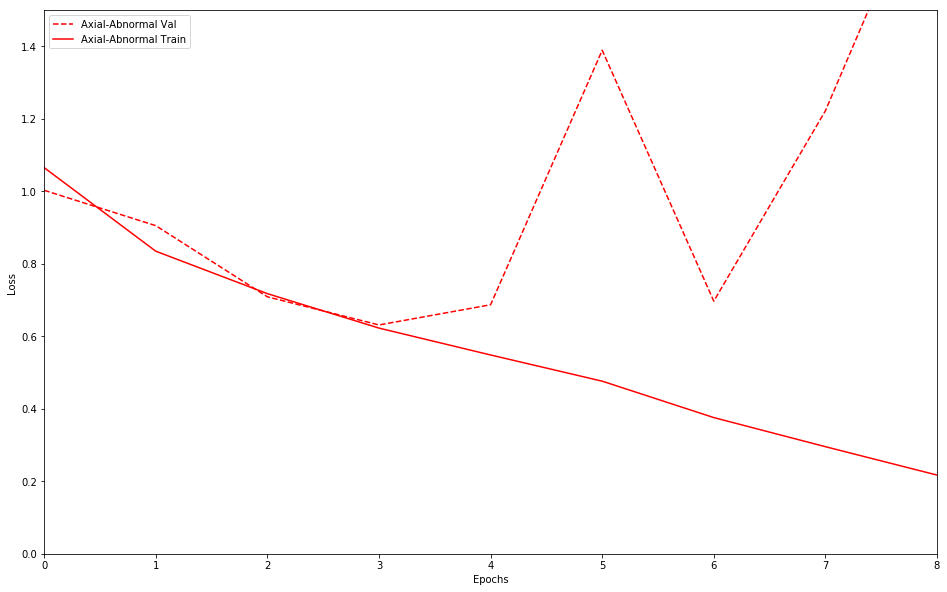

In [0]:
model = build_model()
history = train_model(model,"axial","abnormal")
plot_history([('Axial-Abnormal',history)])

## Model 3: Axial Plane and Meniscus Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/100

Epoch 00001: val_acc improved from -inf to 0.55000, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_meniscus.h5
 - 16s - loss: 1.1249 - acc: 0.5416 - val_loss: 1.0056 - val_acc: 0.5500
Epoch 2/100

Epoch 00002: val_acc improved from 0.55000 to 0.57500, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_meniscus.h5
 - 7s - loss: 1.0611 - acc: 0.5522 - val_loss: 0.9800 - val_acc: 0.5750
Epoch 3/100

Epoch 00003: val_acc improved from 0.57500 to 0.60000, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_meniscus.h5
 - 7s - loss: 1.0224 - acc: 0.5690 - val_loss: 0.9702 - val_acc: 0.6000
Epoch 4/100

Epoch 00004: val_acc improved from 0.60000 to 0.64167, saving model to /content/gdrive/My Drive/Models/TransferLearning/axial_meniscus.h5
 - 7s - loss: 1.0010 - acc: 0.5814 - val_loss: 0.9585 - val_acc: 0.6417
Epoch 5/100

Epoch 00005: val_acc did not improve from 0.64167


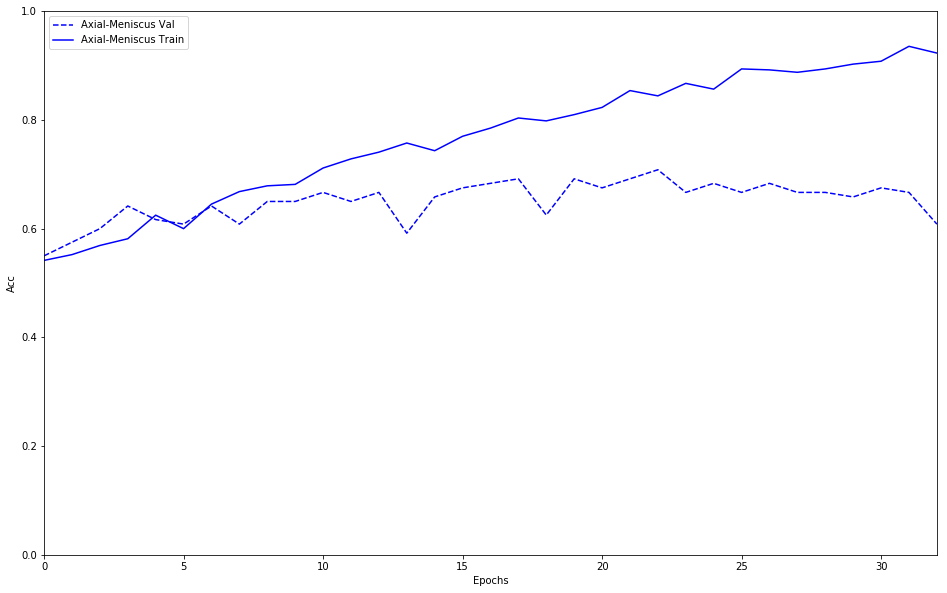

<Figure size 432x288 with 0 Axes>

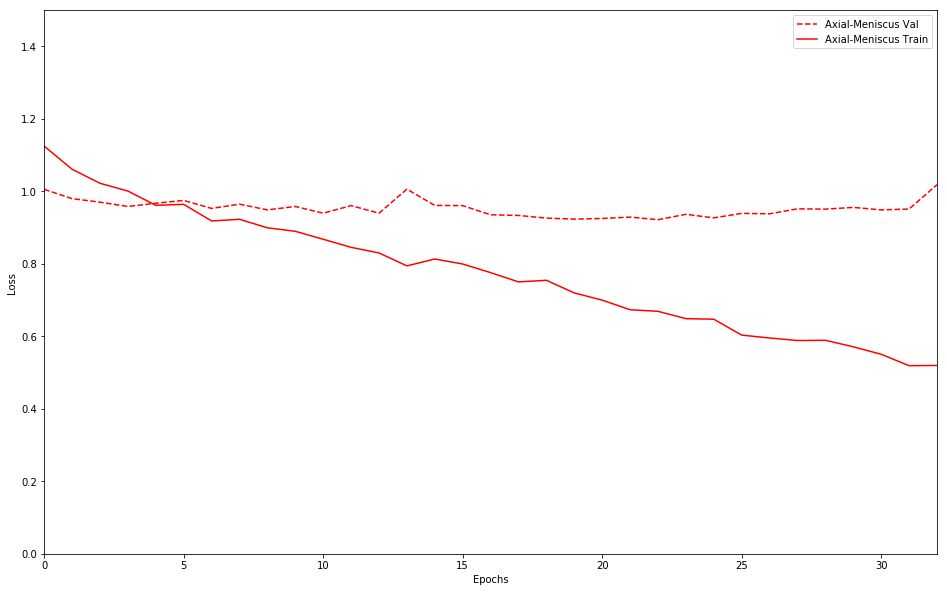

In [36]:
model = build_model()
history = train_model(model,"axial","meniscus")
plot_history([('Axial-Meniscus',history)])

## Model 4: Coronol Plane and ACL Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.50833, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_acl.h5
 - 16s - loss: 0.9583 - acc: 0.5451 - val_loss: 0.8840 - val_acc: 0.5083
Epoch 2/50

Epoch 00002: val_acc improved from 0.50833 to 0.56667, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_acl.h5
 - 7s - loss: 0.8803 - acc: 0.5699 - val_loss: 0.8665 - val_acc: 0.5667
Epoch 3/50

Epoch 00003: val_acc improved from 0.56667 to 0.61667, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_acl.h5
 - 7s - loss: 0.8741 - acc: 0.6319 - val_loss: 0.8636 - val_acc: 0.6167
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.61667
 - 6s - loss: 0.8535 - acc: 0.6442 - val_loss: 0.8656 - val_acc: 0.5500
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.61667
 - 6s - loss: 0.8526 - acc: 0.6690 - val_loss: 0.8718 - val_acc: 0.6000
Epoch 6/50

Epoch 00006: val_a

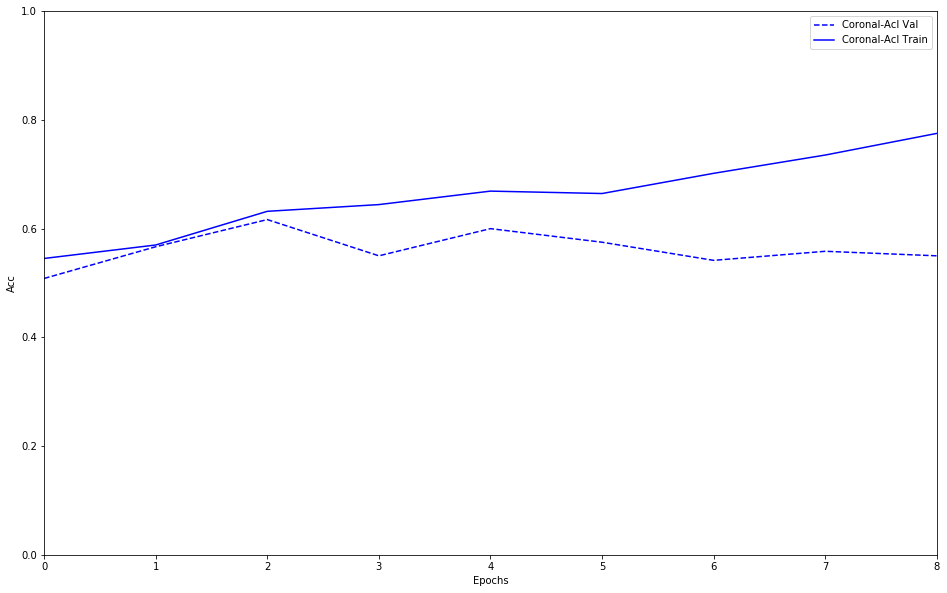

<Figure size 432x288 with 0 Axes>

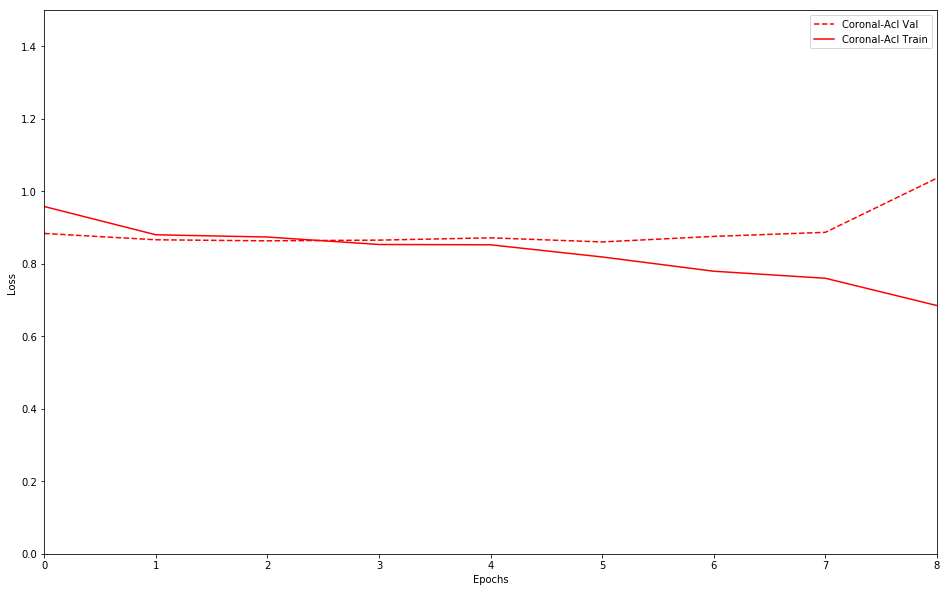

In [50]:
model = build_model()
history = train_model(model,"coronal","acl")
plot_history([('Coronal-ACL',history)])

## Model 5: Coronol Plane and Abnormal Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.72500, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_abnormal.h5
 - 14s - loss: 1.1068 - acc: 0.5628 - val_loss: 0.9242 - val_acc: 0.7250
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.72500
 - 6s - loss: 0.9812 - acc: 0.6487 - val_loss: 0.9212 - val_acc: 0.7000
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.72500
 - 6s - loss: 0.9318 - acc: 0.6991 - val_loss: 0.9689 - val_acc: 0.5917
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.72500
 - 6s - loss: 0.8811 - acc: 0.7097 - val_loss: 1.0266 - val_acc: 0.5083
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.72500
 - 6s - loss: 0.8275 - acc: 0.7664 - val_loss: 0.9161 - val_acc: 0.6583
Epoch 6/50

Epoch 00006: val_acc improved from 0.72500 to 0.79167, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_abnormal.h5
 - 8s - loss: 0.7674 - acc: 0.8186 - val_lo

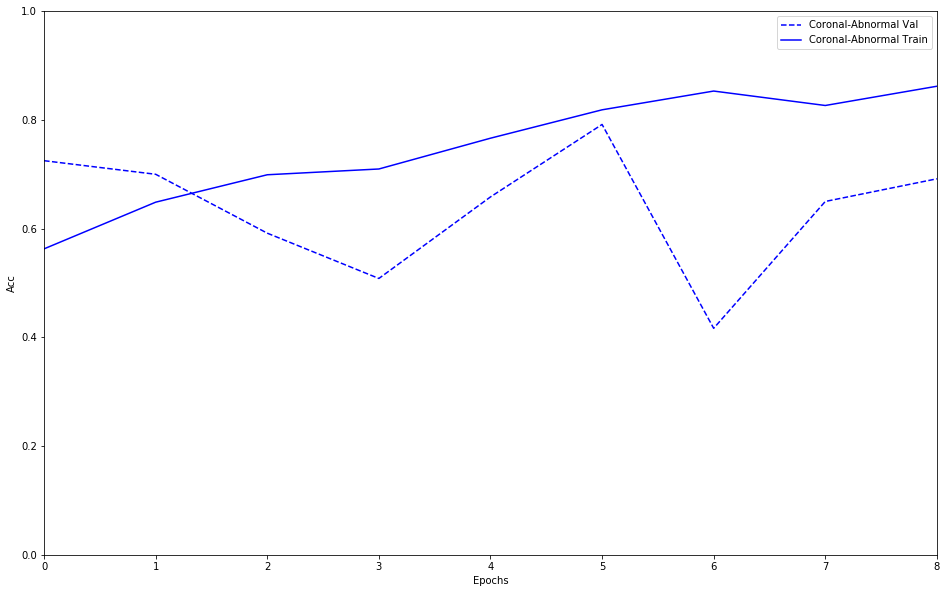

<Figure size 432x288 with 0 Axes>

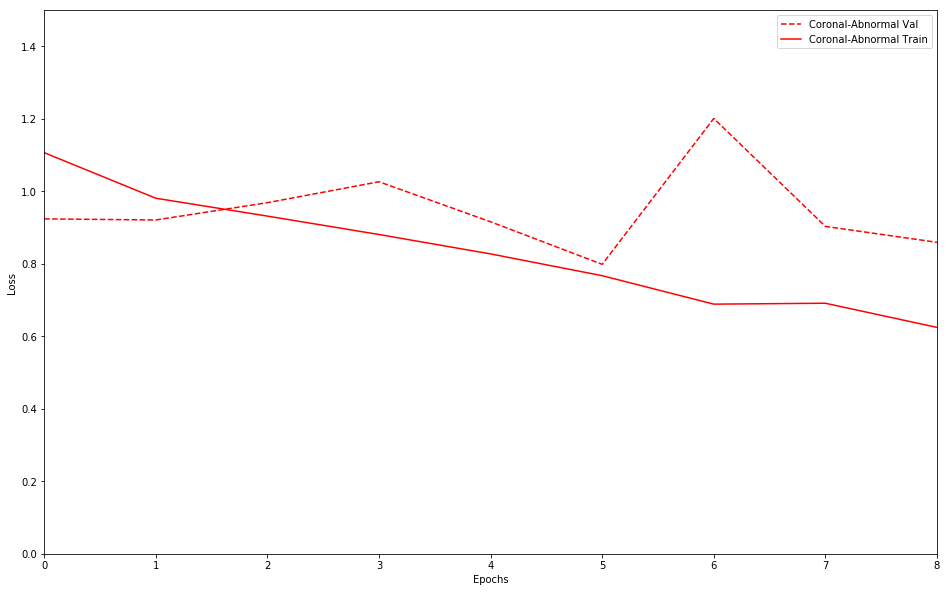

In [0]:
model = build_model()
history = train_model(model,"coronal","abnormal")
plot_history([('Coronal-Abnormal',history)])

## Model 6: Coronol Plane and Meniscus Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.45000, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_meniscus.h5
 - 16s - loss: 1.0996 - acc: 0.5531 - val_loss: 1.0499 - val_acc: 0.4500
Epoch 2/50

Epoch 00002: val_acc improved from 0.45000 to 0.58333, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_meniscus.h5
 - 7s - loss: 1.0167 - acc: 0.5735 - val_loss: 0.9777 - val_acc: 0.5833
Epoch 3/50

Epoch 00003: val_acc improved from 0.58333 to 0.63333, saving model to /content/gdrive/My Drive/Models/TransferLearning/coronal_meniscus.h5
 - 7s - loss: 0.9740 - acc: 0.6274 - val_loss: 0.9751 - val_acc: 0.6333
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.63333
 - 6s - loss: 0.9656 - acc: 0.6372 - val_loss: 0.9693 - val_acc: 0.5583
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.63333
 - 6s - loss: 0.9311 - acc: 0.6823 - val_loss: 0.9617 - val_acc: 0.6000
Epoch 6/50

Epo

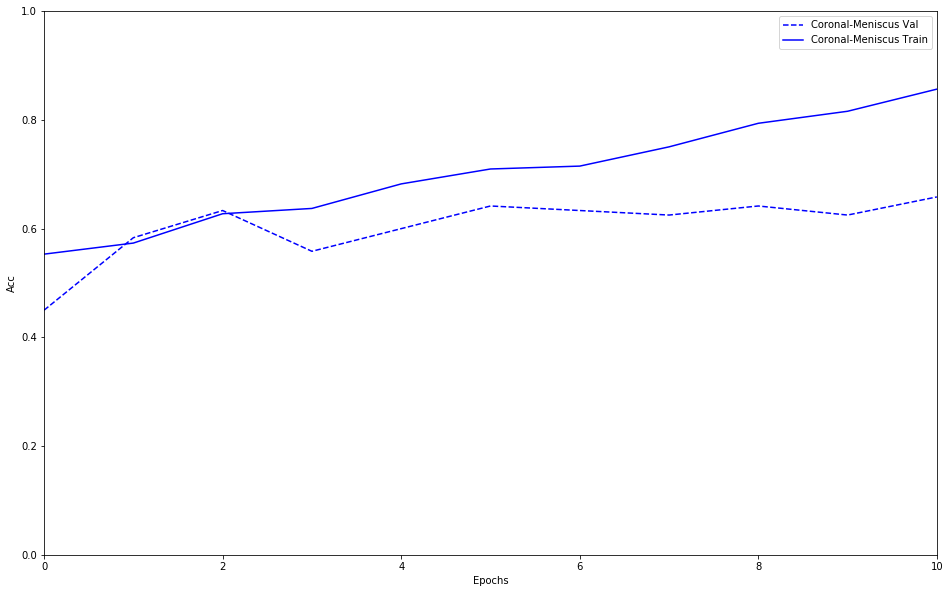

<Figure size 432x288 with 0 Axes>

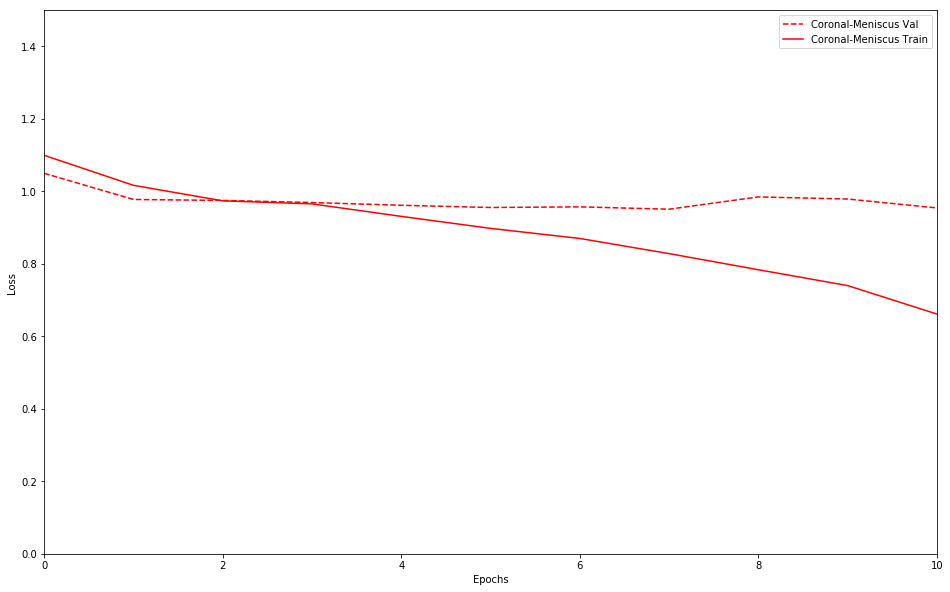

In [0]:
model = build_model()
history = train_model(model,"coronal","meniscus")
plot_history([('Coronal-Meniscus',history)])

## Model 7: Sagittal Plane and ACL Labels

In [0]:
model = build_model()
history = train_model(model,"sagittal","acl")
plot_history([('Sagittal-Meniscus',history)])

Train on 1130 samples, validate on 120 samples


## Model 8: Sagittal Plane and Abnormal Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.79167, saving model to /content/gdrive/My Drive/Models/TransferLearning/sagittal_abnormal.h5
 - 23s - loss: 1.0668 - acc: 0.5584 - val_loss: 1.5503 - val_acc: 0.7917
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.79167
 - 6s - loss: 0.8664 - acc: 0.7115 - val_loss: 1.4010 - val_acc: 0.7917
Epoch 3/50

Epoch 00003: val_acc improved from 0.79167 to 0.80000, saving model to /content/gdrive/My Drive/Models/TransferLearning/sagittal_abnormal.h5
 - 8s - loss: 0.7560 - acc: 0.7080 - val_loss: 0.9348 - val_acc: 0.8000
Epoch 4/50

Epoch 00004: val_acc improved from 0.80000 to 0.83333, saving model to /content/gdrive/My Drive/Models/TransferLearning/sagittal_abnormal.h5
 - 7s - loss: 0.6792 - acc: 0.7584 - val_loss: 0.8042 - val_acc: 0.8333
Epoch 5/50

Epoch 00005: val_acc did not improve from 0.83333
 - 6s - loss: 0.5961 - acc: 0.8159 - val_loss: 0.6469 - val_acc: 0.8250
Epoch 6/50



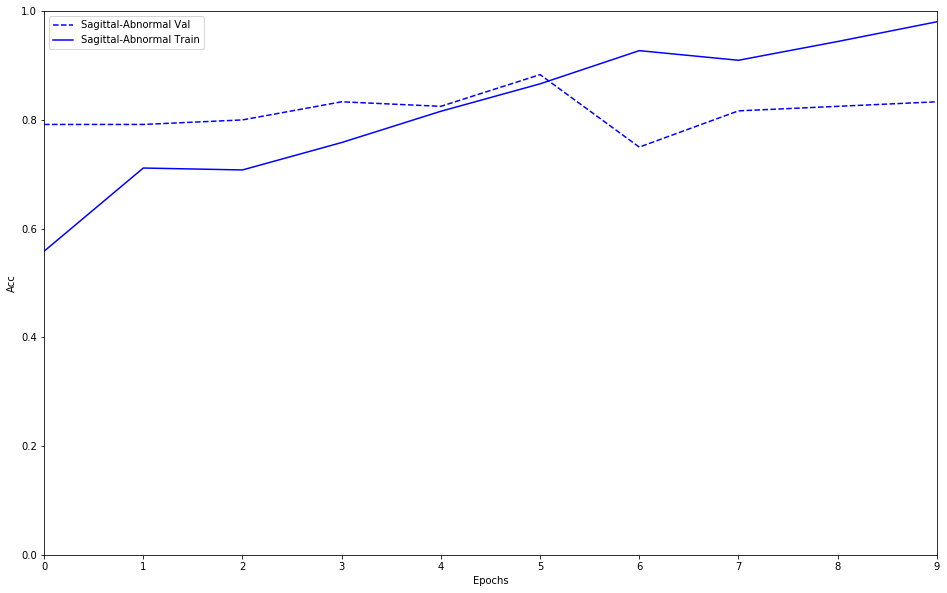

<Figure size 432x288 with 0 Axes>

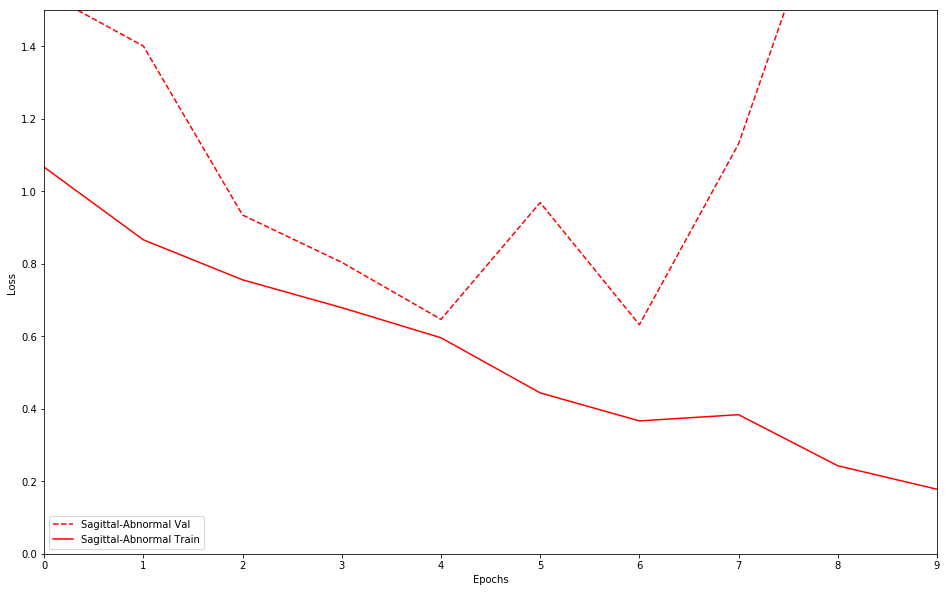

In [0]:
model = build_model()
history = train_model(model,"sagittal","abnormal")
plot_history([('Sagittal-Abnormal',history)])

## Model 9: Sagittal Plane and Meniscus Labels

Train on 1130 samples, validate on 120 samples
Epoch 1/50

Epoch 00001: val_acc improved from -inf to 0.58333, saving model to /content/gdrive/My Drive/Models/TransferLearning/sagittal_meniscus.h5
 - 23s - loss: 1.0663 - acc: 0.5009 - val_loss: 0.9167 - val_acc: 0.5833
Epoch 2/50

Epoch 00002: val_acc did not improve from 0.58333
 - 6s - loss: 0.9159 - acc: 0.5106 - val_loss: 0.8971 - val_acc: 0.5667
Epoch 3/50

Epoch 00003: val_acc did not improve from 0.58333
 - 6s - loss: 0.8765 - acc: 0.5106 - val_loss: 0.8588 - val_acc: 0.5667
Epoch 4/50

Epoch 00004: val_acc did not improve from 0.58333
 - 6s - loss: 0.8452 - acc: 0.5292 - val_loss: 0.8308 - val_acc: 0.5750
Epoch 5/50

Epoch 00005: val_acc improved from 0.58333 to 0.64167, saving model to /content/gdrive/My Drive/Models/TransferLearning/sagittal_meniscus.h5
 - 8s - loss: 0.8171 - acc: 0.5027 - val_loss: 0.8071 - val_acc: 0.6417
Epoch 6/50

Epoch 00006: val_acc improved from 0.64167 to 0.65833, saving model to /content/gdrive/My D

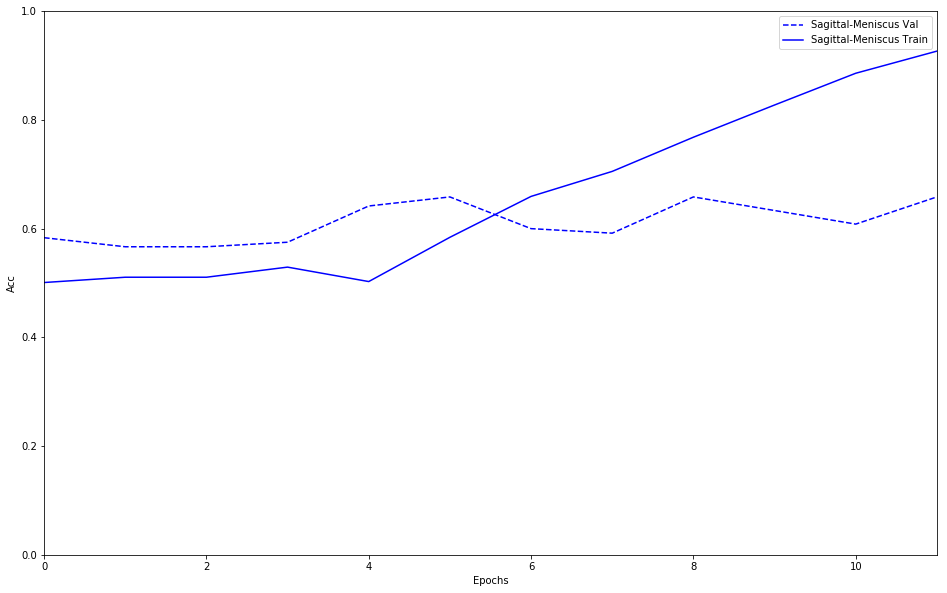

<Figure size 432x288 with 0 Axes>

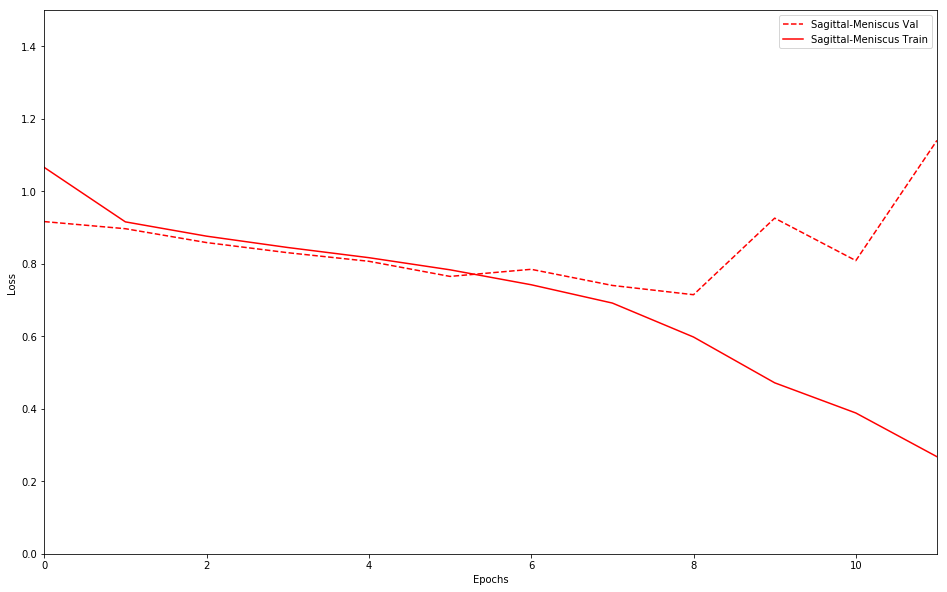

In [0]:
model = build_model()
history = train_model(model,"sagittal","meniscus")
plot_history([('Sagittal-Meniscus',history)])